In [2]:
import numpy as np
import pandas as pd
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os

In [3]:
def load_data(filename,participant_id):
    df = pd.read_csv(direc + filename,header=None,names=['participant_id','i','ts','info'])
    events = [json.loads(e) for e in df[df['participant_id']==participant_id]['info']]
    return sorted(events,key=lambda e:e['event_time'])

def get_events_with_condition(f,condition):
    return [e for e in f if condition(e)]

def get_event_with_condition(f,condition):
    x = get_events_with_condition(f,condition)
    if len(x)==1:
        return x[0]
    else:
        return {}
    
def get_events_with_type(f,event_type):
    return get_events_with_condition(f,lambda e: e['event_type'].replace('_',' ')==event_type.replace('_',' '))

def get_event_with_type(f,event_type):
    return get_event_with_condition(f,lambda e: e['event_type'].replace('_',' ')==event_type.replace('_',' '))

#helper functions that encode boards as and moves as integers for the model fitting pipeline
def encode_board(pieces):
    return np.sum([2**i for i,p in enumerate(pieces) if p=='1']).astype(np.int64)

def encode_move(m):
    return 2**m

def get_parsed_data(data):
    your_turn_events = get_events_with_type(data,'your turn')
    user_move_events = get_events_with_type(data,'user move')
    assert(len(your_turn_events)==len(user_move_events))
    return [(e['event_info']['bp'],e['event_info']['wp'],e['event_info']['tile'],
             e['event_info']['user_color'],(e['event_time']-e_your_turn['event_time'])/1000)
            for e_your_turn,e in zip(your_turn_events,user_move_events)]

def check_event_counts(data,num_games):
    event_count_dict = defaultdict(lambda: 0, dict(zip(*np.unique([e['event_type'] for e in data],return_counts=True))))
    print(dict(event_count_dict))
    assert('start game' in event_count_dict and event_count_dict['start game']==num_games)
    assert('end game' in event_count_dict and event_count_dict['end game']==num_games)
    assert(event_count_dict['user move']==event_count_dict['your turn'])
    assert(event_count_dict['opponent move']==event_count_dict['waiting for opponent'])
    assert(event_count_dict['opponent win'] + event_count_dict['user win'] + event_count_dict['draw'] == event_count_dict['start game'])

In [25]:
def display_board(bp,wp,move,color):
    fig = plt.figure()
    ax = fig.add_subplot(111,aspect='equal')
    rec = patches.Rectangle((-0.5,-0.5),9,4,color="gray",fill=True,zorder=1)
    ax.add_patch(rec)
    ax.vlines(np.arange(-0.5,9.5,1),-0.5,3.5)
    ax.hlines(np.arange(-0.5,4.5,1),-0.5,8.5)
    for i in range(36):
        if(bp[i]=='1'):
            circ = patches.Circle((i%9,3-i//9),0.33,color="black",fill=True)
            circ = ax.add_patch(circ)
        if(wp[i]=='1'):
            circ = patches.Circle((i%9,3-i//9),0.33,color="white",fill=True)
            circ = ax.add_patch(circ)
    circ = patches.Circle((move%9,3-move//9),0.33,color=color,fill=False)
    circ = ax.add_patch(circ)
    ax.axis('off')
    plt.show()

In [26]:
# directory where your data is stored
direc = 'C:/Users/svo/Documents/FourinarowData/'
#name of the user whose data you want to analyze
usernames = ['109:R_1NurOLY6ru1XwrL','130:R_10pkDu4x8ARiMHf','124:R_cOwNfKZ17YDGcGR']
#name of your data file
filename = 'Pilotdata_8yo.csv'

In [27]:
data = [load_data(filename,username) for username in usernames]

In [28]:
#the second argument in check_data is the number of games that ought to exist for this user
#if this function failes an assertion, something is wrong with your data
#this function will print the count of all the event type in the data
for d in data:
    check_event_counts(d,12)
    for bp,wp,m,c,rt in get_parsed_data(d):
        assert(len(bp.split('1'))-len(bp.split('1')) in [0,1])
    

{'adjust level': 12, 'end game': 12, 'opponent move': 77, 'opponent win': 10, 'quiz answer': 5, 'show instructions': 16, 'start game': 12, 'user move': 73, 'user win': 2, 'waiting for opponent': 77, 'your turn': 73}
{'adjust level': 12, 'end game': 12, 'opponent move': 82, 'opponent win': 6, 'quiz answer': 5, 'show instructions': 16, 'start game': 12, 'user move': 82, 'user win': 6, 'waiting for opponent': 82, 'your turn': 82}
{'adjust level': 12, 'end game': 12, 'opponent move': 98, 'opponent win': 3, 'quiz answer': 5, 'show instructions': 16, 'start game': 12, 'user move': 101, 'user win': 9, 'waiting for opponent': 98, 'your turn': 101}


In [59]:
def save_data(data):
    if not os.path.exists(direc + 'raw/'):
        os.mkdir(direc + 'raw/')
    if not os.path.exists(direc + 'splits/'):
        os.mkdir(direc + 'splits/')
    for i,(d,username) in enumerate(zip(data,usernames)):
        parsed_data = get_parsed_data(d)
        with open(direc + 'raw/' + username.split(':')[0] + '.csv','w') as f:
            df = pd.DataFrame([(encode_board(bp),encode_board(wp),c.upper(),encode_move(m),rt,username.split(':')[0]) for bp,wp,m,c,rt in parsed_data])
            f.write(df.to_csv(None, index = False, header=False,sep='\t',line_terminator ='\n')[:-1])
        group = (5*(np.random.permutation(len(parsed_data))/len(parsed_data))).astype(int)+1
        if not os.path.exists(direc + 'splits/' + str(i+1)):
            os.mkdir(direc + 'splits/' + str(i+1))
        with open(direc + 'splits/' + str(i+1) + '/data.csv','w') as f:
            df = pd.DataFrame([(encode_board(bp),encode_board(wp),c.upper(),encode_move(m),rt,g,username.split(':')[0]) for (bp,wp,m,c,rt),g in zip(parsed_data,group)])
            f.write(df.to_csv(None, index = False, header=False,sep='\t',line_terminator ='\n')[:-1])
        for g in range(1,6):
            with open(direc + 'splits/' + str(i+1) + '/' + str(g) + '.csv','w') as f:
                df = pd.DataFrame([(encode_board(bp),encode_board(wp),c.upper(),encode_move(m),rt,g,username.split(':')[0]) for (bp,wp,m,c,rt),g in zip(parsed_data,group)])
                f.write(df[df[5]==g].to_csv(None, index = False, header=False,sep='\t',line_terminator ='\n')[:-1])


In [60]:
save_data(data)

000000000000000000000000000000000000 000000000000000000000000000000000000 32 black 2.572


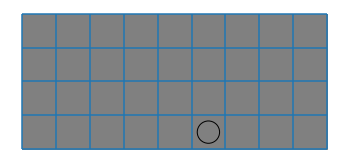

000000000000000000000000000000001000 000000000000000000010000000000000000 23 black 1.311


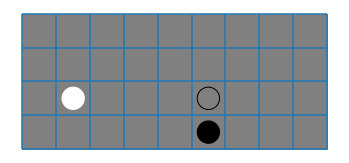

000000000000000000000001000000001000 000001000000000000010000000000000000 24 black 1.176


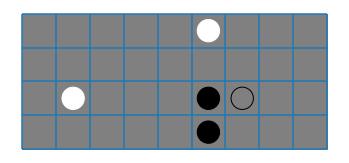

000000000000000000000001100000001000 000001100000000000010000000000000000 33 black 0.76


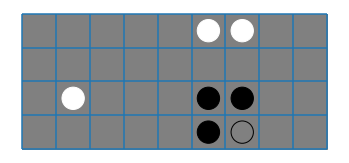

000000000000000000000001100000001100 000011100000000000010000000000000000 22 black 1.457


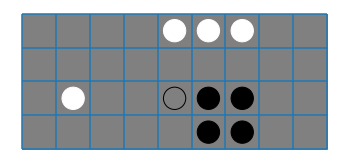

000000000000010000000000000000000000 000000000000000000000000000000000000 14 white 2.895


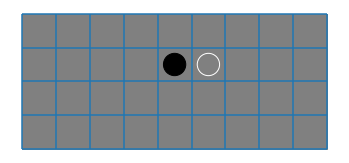

000000000000010000000010000000000000 000000000000001000000000000000000000 31 white 2.464


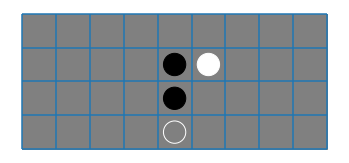

000000000000010000000110000000000000 000000000000001000000000000000010000 20 white 2.138


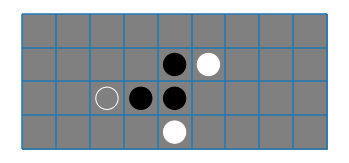

000000000000110000000110000000000000 000000000000001000001000000000010000 3 white 2.124


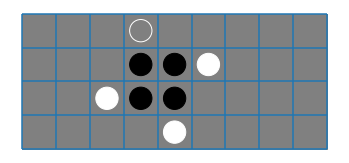

000000000000110000000110100000000000 000100000000001000001000000000010000 23 white 4.002


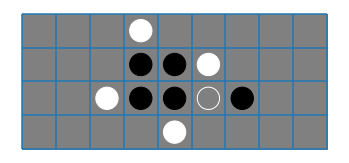

000001000000110000000110100000000000 000100000000001000001001000000010000 29 white 2.735


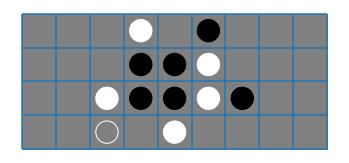

000001000001110000000110100000000000 000100000000001000001001000001010000 10 white 4.401


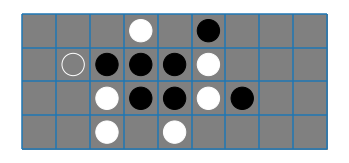

000001000001110000000110100000001000 000100000010001000001001000001010000 16 white 4.505


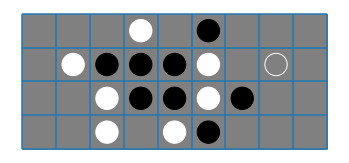

000000000000000000000000000000000000 000000000000000000000000000000000000 4 black 3.371


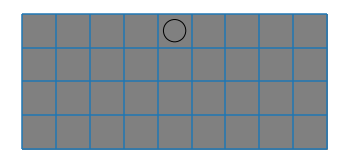

000010000000000000000000000000000000 000000001000000000000000000000000000 13 black 1.361


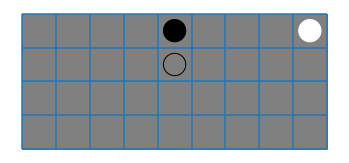

000010000000010000000000000000000000 000000011000000000000000000000000000 6 black 4.41


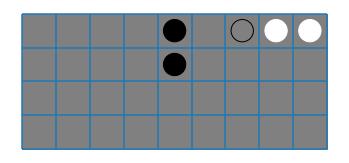

000010100000010000000000000000000000 001000011000000000000000000000000000 22 black 4.059


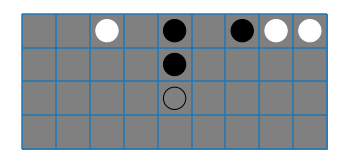

000010100000010000000010000000000000 001000011000000000000000000000100000 31 black 1.69


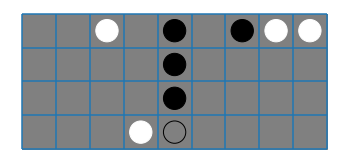

000000000000000001000000000000000000 000000000000000000000000000000000000 16 white 2.571


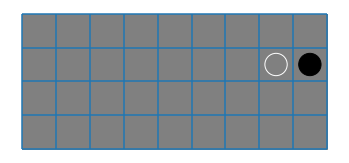

000000000000010001000000000000000000 000000000000000010000000000000000000 14 white 1.951


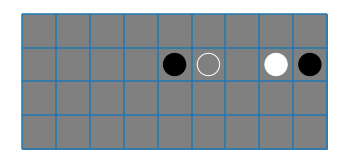

000000100000010001000000000000000000 000000000000001010000000000000000000 7 white 1.835


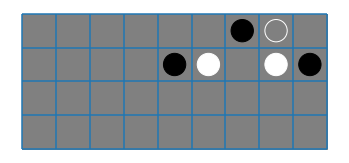

000000100000110001000000000000000000 000000010000001010000000000000000000 11 white 2.452


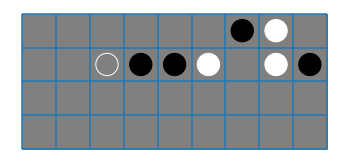

000010100000110001000000000000000000 000000010001001010000000000000000000 3 white 1.598


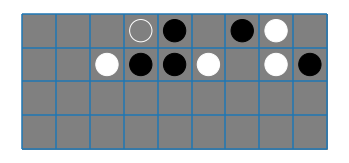

000010100000110001000010000000000000 000100010001001010000000000000000000 31 white 1.989


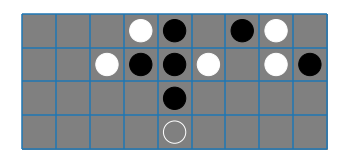

000010100000110001000011000000000000 000100010001001010000000000000010000 24 white 1.851


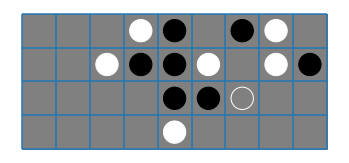

000010100000110001001011000000000000 000100010001001010000000100000010000 25 white 1.245


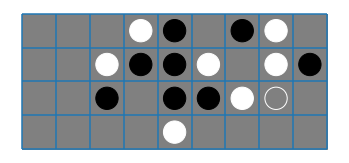

000000000000000000000000000000000000 000000000000000000000000000000000000 13 black 6.078


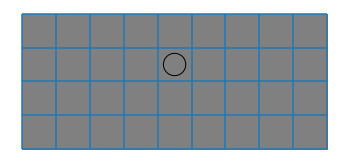

000000000000010000000000000000000000 000000000000000000000000000100000000 22 black 1.726


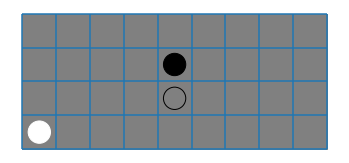

000000000000010000000010000000000000 000000000000000000000000000101000000 31 black 1.878


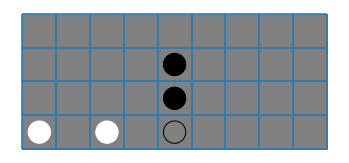

000000000000010000000010000000010000 000010000000000000000000000101000000 28 black 2.073


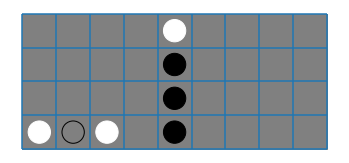

000000000000010000000010000010010000 000110000000000000000000000101000000 12 black 2.263


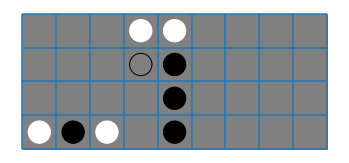

000000000000110000000010000010010000 001110000000000000000000000101000000 1 black 4.351


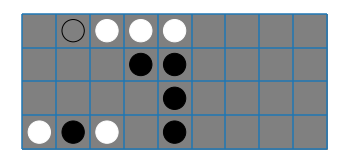

010000000000000000000000000000000000 000000000000000000000000000000000000 4 white 0.761


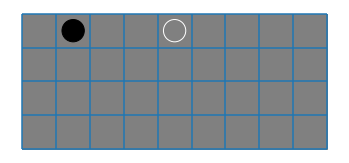

110000000000000000000000000000000000 000010000000000000000000000000000000 9 white 2.534


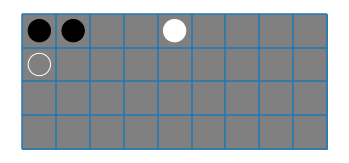

110000000000000100000000000000000000 000010000100000000000000000000000000 2 white 1.15


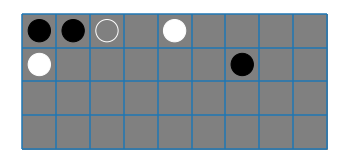

110000000000000100000100000000000000 001010000100000000000000000000000000 22 white 1.462


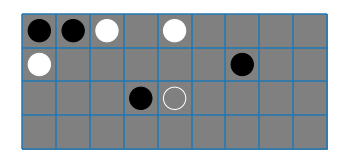

110000000000000100000100000000010000 001010000100000000000010000000000000 33 white 1.749


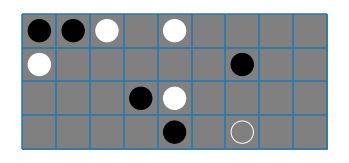

000000000000000000000000000000000000 000000000000000000000000000000000000 30 black 1.262


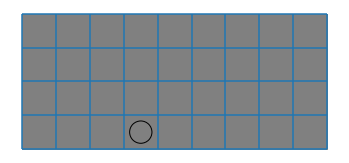

000000000000000000000000000000100000 000000000000000000010000000000000000 22 black 1.12


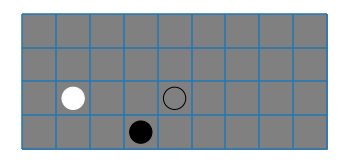

000000000000000000000010000000100000 000000000000010000010000000000000000 14 black 0.936


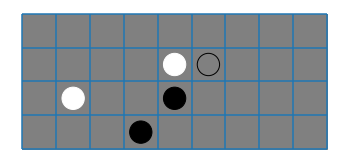

000000000000001000000010000000100000 000000100000010000010000000000000000 5 black 1.127


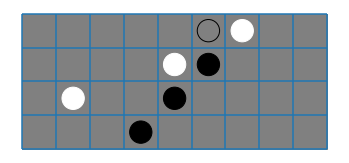

000001000000001000000010000000100000 000000100010010000010000000000000000 23 black 0.749


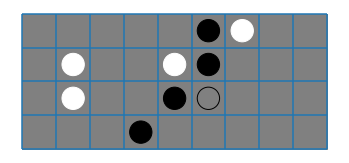

000001000000001000000011000000100000 000000100011010000010000000000000000 32 black 1.182


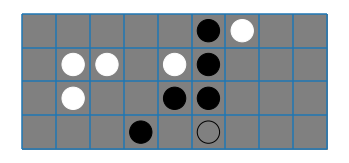

000000000000010000000000000000000000 000000000000000000000000000000000000 3 white 0.316


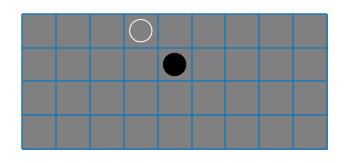

000000000000010000000000000000001000 000100000000000000000000000000000000 14 white 1.458


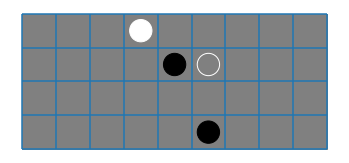

000000000000010000000000010000001000 000100000000001000000000000000000000 11 white 3.057


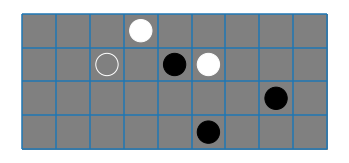

000000000000010000010000010000001000 000100000001001000000000000000000000 20 white 1.511


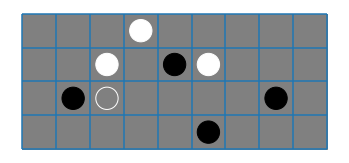

000000000000010000010000010001001000 000100000001001000001000000000000000 2 white 1.535


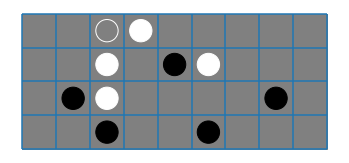

000000001000010000010000010001001000 001100000001001000001000000000000000 7 white 1.805


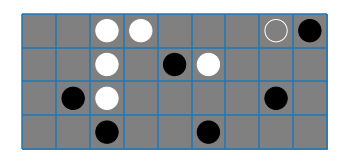

000000001000010000010000010001101000 001100010001001000001000000000000000 31 white 1.324


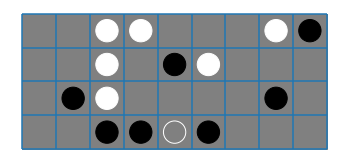

000010001000010000010000010001101000 001100010001001000001000000000010000 22 white 1.64


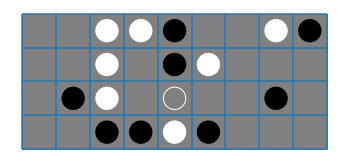

000010001000010000010100010001101000 001100010001001000001010000000010000 12 white 1.346


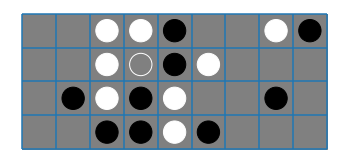

000000000000000000000000000000000000 000000000000000000000000000000000000 12 black 3.178


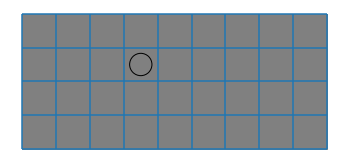

000000000000100000000000000000000000 000000000000000000000000000000100000 31 black 0.715


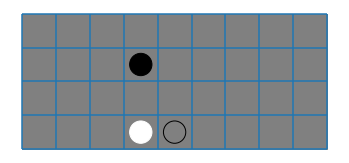

000000000000100000000000000000010000 000000000000000000000100000000100000 22 black 1.053


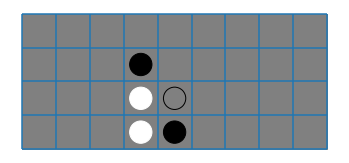

000000000000100000000010000000010000 000000000000000100000100000000100000 8 black 2.208


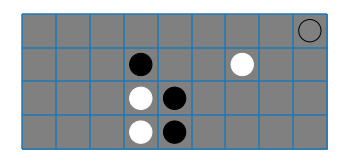

000000001000100000000010000000010000 000000000000000100000100000000100100 16 black 0.854


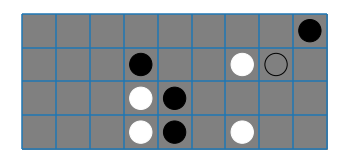

000000001000100010000010000000010000 000000000000000100000101000000100100 24 black 0.754


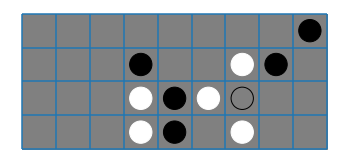

000000001000100010000010100000010000 000000000000000100000101000000101100 14 black 1.462


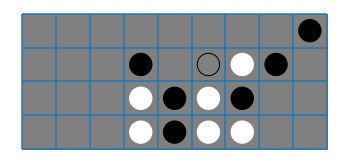

000000001000101010000010100000010000 000000000000010100000101000000101100 4 black 1.747


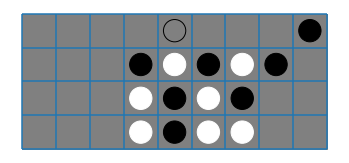

000000000000000000000000000000000100 000000000000000000000000000000000000 23 white 2.756


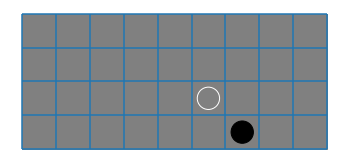

000000000000000000000000000000001100 000000000000000000000001000000000000 31 white 1.935


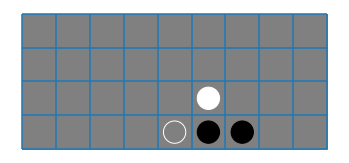

000000000000000000000010000000001100 000000000000000000000001000000010000 24 white 1.244


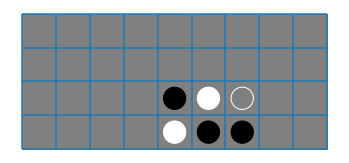

000000000000100000000010000000001100 000000000000000000000001100000010000 34 white 1.209


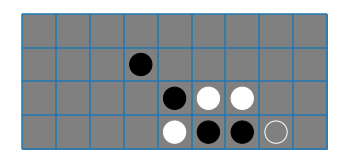

000000000000000000000000000000000000 000000000000000000000000000000000000 21 black 1.981


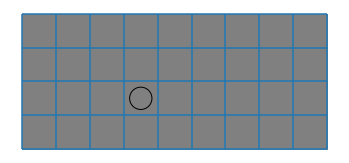

000000000000000000000100000000000000 000000000000001000000000000000000000 23 black 1.328


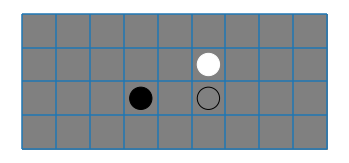

000000000000000000000101000000000000 000000000000001000001000000000000000 29 black 1.88


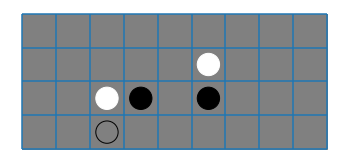

000000000000000000000101000001000000 000000000000001100001000000000000000 4 black 1.223


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [29]:
for d in data:
    for bp,wp,m,c,rt in get_parsed_data(d):
        print(bp,wp,m,c,rt)
        display_board(bp,wp,m,c)

In [30]:
[len(get_parsed_data(d)) for d in data]

[73, 82, 101]

In [51]:
np.std(np.hstack(test_ll1[i]))/np.sqrt(82)

0.17631767108168916

In [1]:
np.argwhere(np.zeros(36)==0)

NameError: name 'np' is not defined